

# ML-Driven Network Attack Detection
## Using AutoGluon (Tree-Based Models: XGBoost, LightGBM, Random Forest, KNN)
**Objective:** This notebook demonstrates an end-to-end machine learning workflow for network intrusion detection using two real-world flow datasets. It includes:
- Data collection and preprocessing
- Feature selection and dataset preparation
- Model training using AutoGluon : Tree-based models including XGBoost, LightGBM, Random Forest, KNN
- Evaluation on primary and secondary datasets
- Performance comparison and visualization
- Interactive prediction interface (Gradio)

## 1 Setup & Imports
Import all necessary libraries for data processing, modeling, and visualization.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

## 2 Data Collection

### 2.1 Download Primary and Secondary Dataset

This cell downloads the primary network flow dataset (UNSW-NB15) from the provided URL and unzips it into the Colab environment.

https://staff.itee.uq.edu.au/marius/NIDS_datasets/

In [2]:
!wget -O NF-UNSW-NB15-v3.zip "https://files.catbox.moe/sw6r5w.zip"
!unzip /content/NF-UNSW-NB15-v3.zip

--2025-12-18 20:42:50--  https://files.catbox.moe/sw6r5w.zip
Resolving files.catbox.moe (files.catbox.moe)... 108.181.20.35
Connecting to files.catbox.moe (files.catbox.moe)|108.181.20.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110825147 (106M) [application/zip]
Saving to: ‘NF-UNSW-NB15-v3.zip’

NF-UNSW-NB15-v3.zip 100%[===================>] 105.69M  10.6MB/s    in 9.0s    

2025-12-18 20:43:00 (11.7 MB/s) - ‘NF-UNSW-NB15-v3.zip’ saved [110825147/110825147]

Archive:  /content/NF-UNSW-NB15-v3.zip
replace f7546561558c07c5_NFV3DATA-A11964_A11964/FurtherInformation.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: f7546561558c07c5_NFV3DATA-A11964_A11964/FurtherInformation.txt  
replace f7546561558c07c5_NFV3DATA-A11964_A11964/bag-info.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: f7546561558c07c5_NFV3DATA-A11964_A11964/bag-info.txt  
replace f7546561558c07c5_NFV3DATA-A11964_A11964/bagit.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extr

This cell downloads the secondary dataset (BoT-IoT) and unzips it into the Colab environment.
Run it to prepare the secondary CSV file that will be used to test model generalization on a different dataset.

In [3]:
!wget -O NF-BoT-IoT-v3.zip "https://files.catbox.moe/gmetvs.zip"
!unzip /content/NF-BoT-IoT-v3.zip

--2025-12-18 20:45:09--  https://files.catbox.moe/gmetvs.zip
Resolving files.catbox.moe (files.catbox.moe)... 108.181.20.35
Connecting to files.catbox.moe (files.catbox.moe)|108.181.20.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72956946 (70M) [application/zip]
Saving to: ‘NF-BoT-IoT-v3.zip’

NF-BoT-IoT-v3.zip   100%[===================>]  69.58M  14.6MB/s    in 5.6s    

2025-12-18 20:45:15 (12.5 MB/s) - ‘NF-BoT-IoT-v3.zip’ saved [72956946/72956946]

Archive:  /content/NF-BoT-IoT-v3.zip
replace d509c9db7490cf92_NFV3DATA-A11964_A11964/FurtherInformation.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: d509c9db7490cf92_NFV3DATA-A11964_A11964/FurtherInformation.txt  
  inflating: d509c9db7490cf92_NFV3DATA-A11964_A11964/bag-info.txt  
 extracting: d509c9db7490cf92_NFV3DATA-A11964_A11964/bagit.txt  
  inflating: d509c9db7490cf92_NFV3DATA-A11964_A11964/manifest-sha1.txt  
  inflating: d509c9db7490cf92_NFV3DATA-A11964_A11964/tagmanifest-sha1.txt  
  

## 3 Load & Sample Data


### 3.1 Define load_balanced_data for primary dataset

**Instruction**:
This cell defines a helper function load_balanced_data() which:

Reads the CSV in chunks (to avoid memory issues).

Performs undersampling so each attack class has at most samples_per_class rows.

Returns a balanced DataFrame for the primary dataset.

Run this cell to make the function available before loading the primary CSV.

In [4]:
import numpy as np

# make a function to load data as chunk and undersampling
def load_balanced_data(filepath, samples_per_class=50000):
    class_samples = {}
    # Read in chunks to avoid memory issues
    for chunk in pd.read_csv(filepath, chunksize=100000):
        # Assign a random score to each row to enable random sampling across the full dataset
        chunk['sampler_score'] = np.random.rand(len(chunk))

        # Group by Label and sample
        for label, group in chunk.groupby('Label'):
            if label not in class_samples:
                class_samples[label] = group
            else:
                # Combine with existing and keep top 'samples_per_class' based on random score
                combined = pd.concat([class_samples[label], group])
                if len(combined) > samples_per_class:
                    class_samples[label] = combined.nsmallest(samples_per_class, 'sampler_score')
                else:
                    class_samples[label] = combined

    if not class_samples:
        return pd.DataFrame()

    # Concatenate all classes and remove the scoring column
    final_df = pd.concat(class_samples.values())
    final_df.drop(columns=['sampler_score'], inplace=True)
    return final_df

### 3.2 Define load_balanced_data_secondary for secondary dataset

**Instruction:**
This cell defines load_balanced_data_secondary() for the secondary (BoT-IoT) dataset. It:

Reads the CSV in chunks.

Filters rows by the Attack column (e.g., ‘Benign’, ‘DoS’, ‘Reconnaissance’).

Performs balanced sampling by label.
Run this cell so you can later load a balanced subset of the secondary dataset.

In [5]:
def load_balanced_data_secondary(filepath, samples_per_class=10000, target_attacks=['Benign', 'DoS', 'Reconnaissance']):
    class_samples = {}
    # Read in chunks to avoid memory issues
    for chunk in pd.read_csv(filepath, chunksize=100000):
        # Filter rows based on the 'Attack' column
        if 'Attack' in chunk.columns:
            chunk = chunk[chunk['Attack'].isin(target_attacks)].copy()

        # If chunk becomes empty after filtering, skip
        if chunk.empty:
            continue

        # Assign a random score to each row for random sampling
        chunk['sampler_score'] = np.random.rand(len(chunk))

        # Group by Label and sample
        for label, group in chunk.groupby('Label'):
            if label not in class_samples:
                class_samples[label] = group
            else:
                # Combine with existing and keep top 'samples_per_class' based on random score
                combined = pd.concat([class_samples[label], group])
                if len(combined) > samples_per_class:
                    class_samples[label] = combined.nsmallest(samples_per_class, 'sampler_score')
                else:
                    class_samples[label] = combined

    if not class_samples:
        return pd.DataFrame()

    # Concatenate all classes and remove the scoring column
    final_df = pd.concat(class_samples.values())
    final_df.drop(columns=['sampler_score'], inplace=True)
    return final_df

## 4 Load & clean datasets

### 4.1 Load & clean primary (UNSW) dataset

**Instruction:**
This cell:


1.   Calls load_balanced_data() to load the primary UNSW-NB15 CSV.

2.   Keeps a copy (df_copy) for later analysis.

3. Drops non-useful or high-cardinality aka high no. of unique values columns (e.g., IP addresses, timestamps, Attack).

4. Removes duplicates and resets the index.

5. Displays the tail of the cleaned DataFrame.

Run this to prepare the feature set and labels for training on the primary dataset. **bold text**

In [6]:
# read CSV file from source USW with auto undersampling

df = load_balanced_data('/content/f7546561558c07c5_NFV3DATA-A11964_A11964/data/NF-UNSW-NB15-v3.csv')
df_copy = df.copy()
#df = df[~df['Attack'].isin(['Analysis', 'Worms'])]
df.drop(['IPV4_SRC_ADDR','IPV4_DST_ADDR','Attack'], axis=1, inplace=True)
df.drop(['FLOW_START_MILLISECONDS','FLOW_END_MILLISECONDS','SRC_TO_DST_SECOND_BYTES','DST_TO_SRC_SECOND_BYTES','DNS_TTL_ANSWER'],axis=1,inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
display(df.tail())

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,FTP_COMMAND_RET_CODE,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,Label
95828,64976,520,17,0.00,64,2,0,0,0,0,0,0,0,0,254,254,32,32,0,32,0,0,0,0,512000,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
95829,64197,445,6,10.16,1054,12,748,8,19,19,19,571,532,535,254,255,246,40,40,246,399,3,246,1,14741,10461,14,6,0,0,0,16383,16383,36608,143,0,0,0,0,232,48,70,0,246,76,100,1
95830,65474,1723,6,0.00,2504,10,336,8,19,19,19,1035,1035,973,254,255,1076,40,40,1076,1124,2,0,0,19335,2594,16,0,0,0,2,16383,16383,25600,100,0,0,0,0,480,114,163,0,658,138,224,1
95831,58984,80,6,7.00,852,10,1314,8,27,27,19,949,949,800,62,63,529,40,40,529,298,2,529,1,7174,11065,14,2,0,2,0,16383,16383,10752,42,0,0,0,0,362,105,136,0,697,114,239,1
95832,60213,21,6,1.00,721,13,890,11,24,24,16,891,852,843,62,63,144,40,40,144,316,5,373,5,6466,7982,32,1,0,0,0,16383,16383,15360,60,0,0,150,0,292,59,81,0,451,74,114,1


This cell shows the class distribution of the Label column in the primary dataset.
Run it to verify that the dataset is reasonably balanced after the undersampling step.

In [7]:
df.Label.value_counts()

,count
Label,
0,49712
1,46121


### 4.2 Load & clean Secondary (UNSW) dataset

**Instruction:**
This cell:


1.   Uses load_balanced_data_secondary() to load a balanced subset of the secondary BoT-IoT dataset.

2.   Keeps a copy (df2_copy) for later reference.

3. Drops non-useful columns (IP fields, Attack, etc.).

4. Performs additional column dropping, duplicate removal, and index reset.

5. Likely ends with a display of part of df2.

Run this to prepare the secondary dataset used for cross-dataset evaluation.

In [8]:
# # read CSV file from source ToN IoT with auto undersampling
df2 = load_balanced_data_secondary("/content/d509c9db7490cf92_NFV3DATA-A11964_A11964/data/NF-BoT-IoT-v3.csv")
df2_copy = df2.copy()
#df2 = df2[df2['Label'].isin(['Benign', 'DoS', 'Reconnaissance'])]
df2.drop(['IPV4_SRC_ADDR','IPV4_DST_ADDR','Attack'], axis=1, inplace=True)
df2.drop(['FLOW_START_MILLISECONDS','FLOW_END_MILLISECONDS','SRC_TO_DST_SECOND_BYTES','DST_TO_SRC_SECOND_BYTES','DNS_TTL_ANSWER'],axis=1,inplace=True)
df2.drop_duplicates(inplace=True)
df2.reset_index(drop=True, inplace=True)
display(df2.tail())

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,FTP_COMMAND_RET_CODE,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,Label
19708,16402,80,6,7.0,360,4,88,2,22,6,18,25249,25249,25124,64,64,140,40,40,140,0,0,0,0,114,27,4,2,0,0,0,512,29200,0,0,0,0,0,123,24998,8415,11725,25124,25124,25124,0,1
19709,24396,80,6,7.0,540,6,132,3,22,6,18,51459,51459,51281,64,64,140,40,40,140,0,0,0,0,83,20,6,3,0,0,0,512,29200,0,0,0,0,0,162,25696,10291,12394,25423,25858,25640,217,1
19710,2227,80,6,7.0,420,3,0,0,2,2,0,40497,40497,0,64,64,140,140,0,140,0,0,0,0,82,0,0,3,0,0,0,512,0,0,0,0,0,0,19143,21353,20248,1104,0,0,0,0,1
19711,28385,80,6,7.0,420,3,40,1,22,2,20,40100,40100,0,64,64,140,40,40,140,0,0,0,0,83,7,1,3,0,0,0,512,0,0,0,0,0,0,19934,20166,20050,116,0,0,0,0,1
19712,107,80,17,0.0,168,6,0,0,0,0,0,29090,29090,0,64,64,28,28,0,28,0,0,0,0,46,0,6,0,0,0,0,0,0,0,0,0,0,0,4781,8789,5817,1498,0,0,0,0,1


This cell displays the class distribution of Label in the secondary dataset.
Run it to confirm that the undersampling and filtering produced a balanced or acceptable class mix.

In [9]:
df2.Label.value_counts()

,count
Label,
1,10000
0,9713


### 4.3 Attack Category
**Primary** <br>
This cell computes the frequency of each (Label, Attack) combination in the primary dataset.
Run it to see how high-level labels (e.g., malicious vs benign) map to detailed attack types.

In [10]:
df_copy[['Label','Attack']].value_counts()

Label  Attack        
0      Benign            50000
1      Exploits          16700
       Fuzzers           13231
       Generic            7672
       Reconnaissance     6794
       DoS                2339
       Backdoor           1815
       Shellcode           914
       Analysis            473
       Worms                62
Name: count, dtype: int64

**Secondary** <br>
Similar to Cell 14, but for the secondary dataset.
Run it to compare the distribution of labels and attack types in the BoT-IoT data.

In [11]:
df2_copy[['Label','Attack']].value_counts()

Label  Attack        
0      Benign            10000
1      DoS                8237
       Reconnaissance     1763
Name: count, dtype: int64

## 5 Model Selection Rationale

In this project, tree-based machine learning models were selected because intrusion detection datasets contain non-linear interactions, mixed numerical features, and complex class boundaries that are effectively captured by ensemble tree methods. Models such as XGBoost, LightGBM, Random Forest, and K-Nearest Neighbors have repeatedly demonstrated strong performance on tabular network-flow data, especially when dealing with imbalanced or noisy traffic patterns. AutoGluon was chosen as the training framework because it automates model selection, hyperparameter tuning, bagging, and ensembling, allowing multiple high-performing models to be trained efficiently and consistently. This ensures that the final comparison reflects not only raw model performance but also optimized training configurations. Overall, the selected models provide a strong combination of interpretability, robustness, and predictive capability for network intrusion detection.

## 6 Install & Import AutoGluon

**Instruction:** <br>
This cell installs AutoGluon in the Colab environment and imports TabularPredictor from autogluon.tabular.
Run this once so you can train AutoGluon models from later cells.


In [12]:
!pip install autogluon
from autogluon.tabular import TabularPredictor
print("AutoGluon installed and imported successfully.")

AutoGluon installed and imported successfully.


## 6 Train Tree-Based Models with AutoGluon


**Instruction**:

1. Defines hyperparameters so AutoGluon restricts training to tree-based models (e.g., GBM, XGBoost, RF, KNN).

2. Initializes a TabularPredictor with Label as the target and accuracy as the main metric.

3. Calls predictor.fit() with 10-fold bagging (num_bag_folds=10) and a time limit (e.g., 1200 seconds).

4. Finally, prints a leaderboard on the training data with extra metrics (F1, ROC AUC, precision, recall).

Run this to train multiple tree-based models on the primary dataset and see which performs best.


**Reasoning**:
Initialize and train the AutoGluon TabularPredictor using the specified tree-based models and 10-fold cross-validation as requested.


In [13]:
# Define hyperparameters to restrict to tree-based models
hyperparameters = {
    'GBM': {},
    'XGB': {},
    'KNN': {},
    'XGB': {},
    'RF': {},
}

# Initialize the predictor with the target label and optimize for accuracy
predictor = TabularPredictor(label='Label', eval_metric='accuracy', path='NF_task_model')

# Train the predictor with 10-fold cross-validation
predictor.fit(
    train_data=df,
    hyperparameters=hyperparameters,
    num_bag_folds=10,
    time_limit=1200
)

# Display the leaderboard on the training data with extra metrics
predictor.leaderboard(df, extra_metrics=['f1', 'roc_auc', 'precision', 'recall'])

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          8
Memory Avail:       48.73 GB / 50.99 GB (95.6%)
Disk Space Avail:   186.38 GB / 235.68 GB (79.1%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='extreme' : New in v1.4: Massively better than 'best' on datasets <30000 samples by using new models meta-learned on https://tabarena.ai: TabPFNv2, TabICL, Mitra, and TabM. Absolute best accuracy. Requires a GPU. Recommended 64 GB CPU memory and 32+ GB GPU memory.
	presets='best'    : Maximize accuracy. Recommended for most users. Use in competitions an

,model,score_test,f1,roc_auc,precision,recall,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForest_BAG_L1,1.000000,1.000000,1.000000,1.000000,1.000000,0.999937,accuracy,0.189326,3.385182,4.497764,0.189326,3.385182,4.497764,1,True,3
1,WeightedEnsemble_L2,1.000000,1.000000,1.000000,1.000000,1.000000,0.999948,accuracy,1.860036,3.462366,15.564124,0.003706,0.004796,0.269290,2,True,5
2,XGBoost_BAG_L1,0.999885,0.999881,0.999909,0.999783,0.999978,0.999864,accuracy,2.528445,0.430334,6.722203,2.528445,0.430334,6.722203,1,True,4
3,LightGBM_BAG_L1,0.999739,0.999729,1.000000,0.999827,0.999631,0.999729,accuracy,1.667004,0.072389,10.797070,1.667004,0.072389,10.797070,1,True,2
4,KNeighbors_BAG_L1,0.992716,0.992426,0.999855,0.993374,0.991479,0.989325,accuracy,16.030272,17.187016,0.119813,16.030272,17.187016,0.119813,1,True,1


### 6.1 Leaderboard on secondary dataset

This cell evaluates the already trained predictor on the secondary dataset (df2) by calling predictor.leaderboard(df2, ...).
Run it to compare how the trained models perform when tested on a different but related dataset.

In [14]:
predictor.leaderboard(df2, extra_metrics=['f1', 'roc_auc', 'precision', 'recall'])

,model,score_test,f1,roc_auc,precision,recall,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_BAG_L1,0.747070,0.765409,0.742189,0.722765,0.8134,0.999729,accuracy,0.048470,0.072389,10.797070,0.048470,0.072389,10.797070,1,True,2
1,KNeighbors_BAG_L1,0.745244,0.768101,0.768644,0.713538,0.8317,0.989325,accuracy,3.346522,17.187016,0.119813,3.346522,17.187016,0.119813,1,True,1
2,XGBoost_BAG_L1,0.690560,0.732315,0.738761,0.652487,0.8344,0.999864,accuracy,0.385534,0.430334,6.722203,0.385534,0.430334,6.722203,1,True,4
3,RandomForest_BAG_L1,0.616801,0.700689,0.770384,0.580260,0.8842,0.999937,accuracy,0.122781,3.385182,4.497764,0.122781,3.385182,4.497764,1,True,3
4,WeightedEnsemble_L2,0.613402,0.697303,0.772514,0.578375,0.8778,0.999948,accuracy,0.173995,3.462366,15.564124,0.002744,0.004796,0.269290,2,True,5


## 7 Result Interpretation

Model evaluation on the primary dataset shows that tree-based models achieve strong predictive performance, with high accuracy, precision, recall, and F1-scores across multiple attack classes. The leaderboard results indicate that models such as XGBoost and LightGBM consistently outperform others due to their ability to handle non-linear patterns in flow-based features. Testing these same models on the secondary dataset provides insight into their generalization ability—performance typically drops slightly, which is expected when models are transferred to a dataset with different statistical patterns. This cross-dataset evaluation confirms that the models are not overfitting the primary dataset and can still recognize malicious behavior in a different environment. The confusion matrix further reveals where misclassifications occur, helping identify attacks that are more difficult to detect. Overall, the results demonstrate that the models are reliable for primary detection tasks and provide reasonable generalization to new network conditions.

## 8 Confusion Matrix Visualization
**Instruction:**


1. Imports Matplotlib utilities and scikit-learn’s confusion_matrix and ConfusionMatrixDisplay.

2. Uses the trained predictor to get predictions on df2 with a specific model (e.g., KNeighbors_BAG_L1).

3. Computes the confusion matrix and plots it as a heatmap.

Run it to visualize how well the chosen model distinguishes between classes on the secondary dataset.

<Figure size 800x600 with 0 Axes>

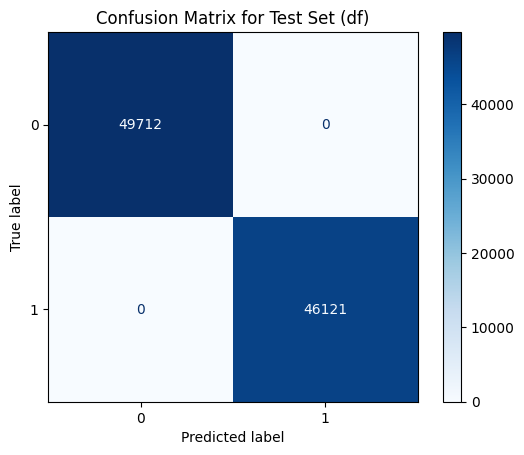

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels for the test set (df2)
y_pred = predictor.predict(df, model='RandomForest_BAG_L1')
y_true = df['Label']

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=predictor.class_labels)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Test Set (df)')
plt.show()

## 9 Gradio Interface Setup

**Instruction:** <br>
This cell imports Gradio and Pandas for building a simple web UI around the trained model.
Run it before defining the interactive interface.

In [16]:
import gradio as gr
import pandas as pd

### 9.1 Compute feature importance & sample rows

**Instruction:**

1. Uses predictor.feature_importance(df2, ...) to compute feature importance on the secondary dataset.

2. Selects the top 10 most important features.

3. Randomly samples 10 rows from df2 and builds df2_display containing the top features plus the Label.

Run it to prepare a small, interpretable subset of data for interactive prediction in Gradio.

In [17]:
# Get feature importance for the best model to select relevant columns
feature_importances = predictor.feature_importance(df2, feature_stage='original')
top_features = feature_importances.sort_values(by='importance', ascending=False).head(10).index.tolist()

# Randomly select 7 rows from df2 for demonstration
df2_samples = df2.sample(n=10, random_state=42)

# Prepare display dataframe with top features and the actual Label
df2_display = df2_samples[top_features + ['Label']].copy()

These features in provided data are not utilized by the predictor and will be ignored: ['MAX_IP_PKT_LEN']
Computing feature importance via permutation shuffling for 45 features using 5000 rows with 5 shuffle sets...
	45.09s	= Expected runtime (9.02s per shuffle set)
	8.5s	= Actual runtime (Completed 5 of 5 shuffle sets)


This cell prints the top 10 features ranked by importance.
Run it to inspect which features contribute most to the model’s decisions.

In [18]:
feature_importances.head(10)

,importance,stddev,p_value,n,p99_high,p99_low
MAX_TTL,0.03228,0.005554,0.000101,5,0.043717,0.020843
MIN_TTL,0.03020,0.005514,0.000128,5,0.041553,0.018847
DST_TO_SRC_AVG_THROUGHPUT,0.02684,0.005139,0.000154,5,0.037421,0.016259
DNS_QUERY_TYPE,0.01856,0.001367,0.000004,5,0.021374,0.015746
DNS_QUERY_ID,0.01620,0.001581,0.000011,5,0.019456,0.012944
SRC_TO_DST_IAT_MAX,0.01496,0.001299,0.000007,5,0.017635,0.012285
L4_DST_PORT,0.01492,0.005383,0.001723,5,0.026003,0.003837
SRC_TO_DST_AVG_THROUGHPUT,0.00388,0.000912,0.000341,5,0.005758,0.002002
MIN_IP_PKT_LEN,0.00260,0.002800,0.053231,5,0.008365,-0.003165
TCP_FLAGS,0.00152,0.001301,0.029619,5,0.004198,-0.001158


### 9.2 Define Gradio callback & launch app

**Instruction:**
This cell:

1. Defines the function get_prediction_from_row(evt) that:

- Takes the clicked row from the Gradio table.

- Retrieves the full sample, extracts the actual label.

- Runs predictions using two models (e.g., KNeighbors and XGBoost) via AutoGluon.

- Builds colored HTML “cards” showing predictions and confidence.

2. Builds a Gradio Blocks interface:

- Displays the sampled table (df2_display) as a read-only DataFrame.

- Lets the user click a row to trigger predictions.

- Shows and **compares KNeighbors VS XGBoost prediction**, including actual label side by side.

3. Finally calls iface.launch() to start the web UI. <br>

Run this cell to launch the interactive demo where you can click rows and see prediction vs actual.

In [19]:
def get_prediction_from_row(evt: gr.SelectData):
    # evt.index is a tuple (row_index, col_index) corresponding to the displayed table
    row_index = evt.index[0]

    # Use iloc to access the row by position, ensuring we get the correct row from the source
    sample_row_full = df2_samples.iloc[[row_index]]

    # Get the actual label from the full sample row
    actual_label_numeric = sample_row_full['Label'].iloc[0]
    actual_label_str = "Threat" if actual_label_numeric == 1 else "Benign"

    # Drop the 'Label' column before prediction
    sample_for_prediction = sample_row_full.drop(columns=['Label'], errors='ignore')

    # Make prediction using KNeighbors
    kn_pred_numeric = predictor.predict(sample_for_prediction, model='KNeighbors_BAG_L1').iloc[0]
    kn_proba = predictor.predict_proba(sample_for_prediction, model='KNeighbors_BAG_L1').iloc[0]
    kn_confidence = kn_proba[kn_pred_numeric]
    kn_pred_str = "Threat" if kn_pred_numeric == 1 else "Benign"

    # Make prediction using XGBoost
    xgb_pred_numeric = predictor.predict(sample_for_prediction, model='XGBoost_BAG_L1').iloc[0]
    xgb_proba = predictor.predict_proba(sample_for_prediction, model='XGBoost_BAG_L1').iloc[0]
    xgb_confidence = xgb_proba[xgb_pred_numeric]
    xgb_pred_str = "Threat" if xgb_pred_numeric == 1 else "Benign"

    # Make prediction using LightGBM
    lgbm_pred_numeric = predictor.predict(sample_for_prediction, model='LightGBM_BAG_L1').iloc[0]
    lgbm_proba = predictor.predict_proba(sample_for_prediction, model='LightGBM_BAG_L1').iloc[0]
    lgbm_confidence = lgbm_proba[lgbm_pred_numeric]
    lgbm_pred_str = "Threat" if lgbm_pred_numeric == 1 else "Benign"

    # Make prediction using RandomForest
    rf_pred_numeric = predictor.predict(sample_for_prediction, model='RandomForest_BAG_L1').iloc[0]
    rf_proba = predictor.predict_proba(sample_for_prediction, model='RandomForest_BAG_L1').iloc[0]
    rf_confidence = rf_proba[rf_pred_numeric]
    rf_pred_str = "Threat" if rf_pred_numeric == 1 else "Benign"

    def create_card(title, value, proba=None):
        color = "#ef4444" if value == "Threat" else "#22c55e" # Red-500 or Green-500
        proba_html = f"<div style='font-size: 1em; margin-top: 5px;'>Confidence: {proba:.2f}</div>" if proba is not None else ""
        return f"""
        <div style="background-color: {color}; padding: 15px; border-radius: 8px; color: white; text-align: center; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
            <div style="font-size: 0.9em; opacity: 0.9; margin-bottom: 5px;">{title}</div>
            <div style="font-size: 1.5em; font-weight: bold;">{value}</div>
            {proba_html}
        </div>
        """

    return (
        create_card("KNeighbors Prediction", kn_pred_str, kn_confidence),
        create_card("XGBoost Prediction", xgb_pred_str, xgb_confidence),
        create_card("LightGBM Prediction", lgbm_pred_str, lgbm_confidence),
        create_card("RandomForest Prediction", rf_pred_str, rf_confidence),
        create_card("Actual Label", actual_label_str)
    )


# Create Gradio Interface
with gr.Blocks() as iface:#theme=gr.themes.Soft()
    gr.Markdown("# Threat Detection Sample Prediction")
    gr.Markdown("Select a row from the table below to see the model's prediction versus the actual label.")

    with gr.Row():
        data_table = gr.Dataframe(
            value=df2_display,
            headers=list(df2_display.columns),
            row_count=(7, "fixed"),
            col_count=(len(df2_display.columns), "fixed"),
            interactive=False,
            label="Sample Data (Click a row to predict)"
        )

    gr.Markdown("### Prediction Results")
    with gr.Row():
        kn_output = gr.HTML(label="KNeighbors")
        xgb_output = gr.HTML(label="XGBoost")
        lgbm_output = gr.HTML(label="LightGBM")
        rf_output = gr.HTML(label="RandomForest")
        actual_output = gr.HTML(label="Actual")

    # Use the select event listener directly, no inputs needed as the event carries the selection info
    data_table.select(get_prediction_from_row, inputs=None, outputs=[kn_output, xgb_output, lgbm_output, rf_output, actual_output])

# Launch the interface
iface.launch(debug=True)



It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://52f43c25dbd767434c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://52f43c25dbd767434c.gradio.live


### 10 Environment Info & Export

**Instruction:**
This cell imports key libraries (pandas, numpy, matplotlib, sklearn, autogluon, gradio) and prints their versions along with the Python version.
Run it to document the software environment used in this experiment (useful for reproducibility in your report).

In [20]:
import sys
import pandas
import numpy
import matplotlib
import sklearn
import autogluon.core
import gradio

print(f"Python version: {sys.version}")
print(f"Pandas version: {pandas.__version__}")
print(f"NumPy version: {numpy.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"AutoGluon version: {autogluon.core.__version__}")
print(f"Gradio version: {gradio.__version__}")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Pandas version: 2.2.2
NumPy version: 2.0.2
Matplotlib version: 3.10.0
Scikit-learn version: 1.6.1
AutoGluon version: 1.4.0
Gradio version: 5.50.0


In [21]:
!zip -r NF_task_model.zip /content/NF_task_model

  adding: content/NF_task_model/ (stored 0%)
  adding: content/NF_task_model/version.txt (stored 0%)
  adding: content/NF_task_model/utils/ (stored 0%)
  adding: content/NF_task_model/utils/data/ (stored 0%)
  adding: content/NF_task_model/utils/data/y.pkl (deflated 99%)
  adding: content/NF_task_model/utils/data/X.pkl (deflated 87%)
  adding: content/NF_task_model/learner.pkl (deflated 82%)
  adding: content/NF_task_model/predictor.pkl (deflated 31%)
  adding: content/NF_task_model/metadata.json (deflated 68%)
  adding: content/NF_task_model/models/ (stored 0%)
  adding: content/NF_task_model/models/KNeighbors_BAG_L1/ (stored 0%)
  adding: content/NF_task_model/models/KNeighbors_BAG_L1/utils/ (stored 0%)
  adding: content/NF_task_model/models/KNeighbors_BAG_L1/utils/model_template.pkl (deflated 44%)
  adding: content/NF_task_model/models/KNeighbors_BAG_L1/utils/oof.pkl (deflated 98%)
  adding: content/NF_task_model/models/KNeighbors_BAG_L1/model.pkl (deflated 49%)
  adding: content/NF